In this notebook, i tried to predict the open price of Tesla Stock by simple RNN Model and LSTM model.<br>
Those who want to have detailed info on simple RNN and LSTM, may refer to great post below:<br>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/


* [1. Loading Data](#1) <br>
* [2.Spliting Data as Train and Validation](#2) <br>
* [3.Creating Train Dataset from Train split](#3) <br>
* [4.Normalization / Feature Scaling](#4) <br>
* [5.Creating X_train and y_train from Train data](#5) <br>
* [6.Creating Simple RNN model](#6) <br>
* [7.Evaluating Model](#7) <br>
* [8.Creating Test Dataset from Validation Data](#8) <br>
* [9.Evaluating with Validation Data](#9) <br>
* [10.Creating LSTM model](#10) <br>
* [11.Evaluating LSTM model](#11) <br>
* [12.Future price prediction](#12) <br>


<a id="1"></a>
## 1.Loading Data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Stock Price Prediction/TSLA.csv")

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.2+ KB


<a id="2"></a>
## 2.Spliting Data as Train and Validation

In [ ]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 2416
Train data length : 1691
Validation data lenth : 725


In [ ]:
train_data = data[:length_train].iloc[:,:2]
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Open
0,2010-06-29,19.000000
1,2010-06-30,25.790001
2,2010-07-01,25.000000
3,2010-07-02,23.000000
4,2010-07-06,20.000000
...,...,...
1686,2017-03-10,246.210007
1687,2017-03-13,244.820007
1688,2017-03-14,246.110001
1689,2017-03-15,257.000000


In [ ]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Date,Open
1691,2017-03-17,264.000000
1692,2017-03-20,260.600006
1693,2017-03-21,262.829987
1694,2017-03-22,251.559998
1695,2017-03-23,255.389999
...,...,...
2411,2020-01-28,568.489990
2412,2020-01-29,575.690002
2413,2020-01-30,632.419983
2414,2020-01-31,640.000000


<a id="3"></a>
## 3.Creating Train Dataset from Train split

* We will get Open column as our dataset
* Dataset to be converted to array by adding `.values`

In [ ]:
dataset_train = train_data.Open.values
dataset_train.shape

(1691,)

In [ ]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(1691, 1)

#### <a id="4"></a>
## 4.Normalization / Feature Scaling

* Dataset values will be in between 0 and 1 after scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(1691, 1)

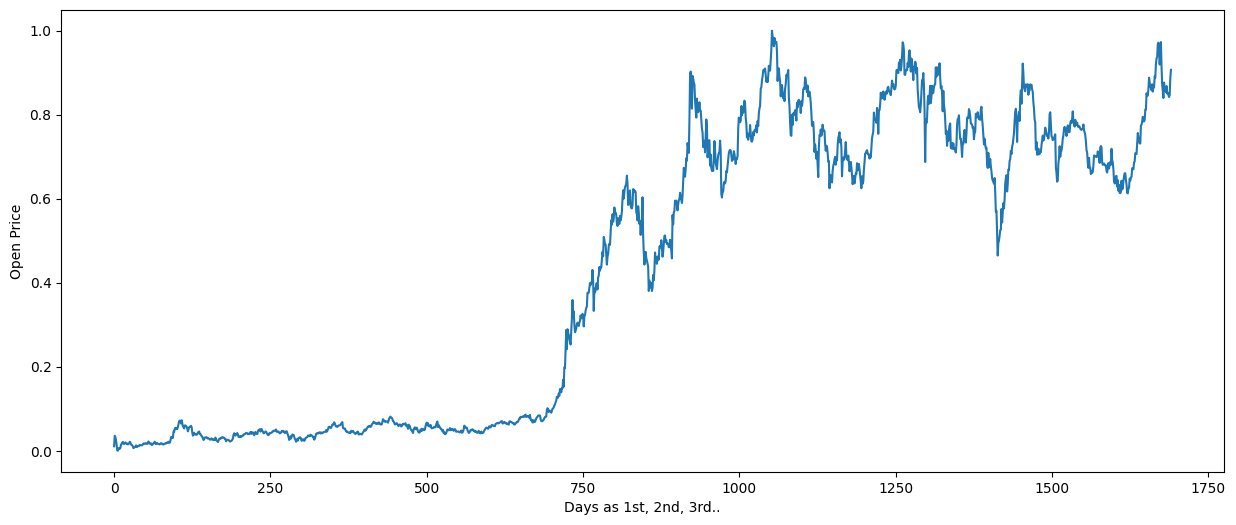

In [ ]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

<a id="5"></a>
## 5.Creating X_train and y_train from Train data

![image.png](attachment:image.png)

* We have train data composed of stock open prices over days
* So, it has 1184 prices corresponding 1184 days
* My aim is to predict the open price of the next day.
* I can use a time step of 50 days.
* I will pick first 50 open prices (0 to 50), 1st 50 price will be in X_train data
* Then predict the price of 51th day; and 51th price will be in y_train data
* Again, i will pick prices from 1 to 51, those will be in X_train data
* Then predict the next days price, 52nd price will be in y_train data

In [ ]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)


In [ ]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (1641, 50)
Shape of y_train before reshape : (1641,)


## Reshape

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (1641, 50, 1)
Shape of y_train after reshape : (1641, 1)


* Shape of X_train : 1641 x 50 x 1
* That means we have 1641 rows, each row has 50 rows and 1 column
* Lets check the first row: it has 50 rows (open prices of 49 days)

In [ ]:
X_train[0]

array([[0.01053291],
       [0.03553936],
       [0.03262991],
       [0.02526425],
       [0.01421574],
       [0.00095754],
       [0.        ],
       [0.00530328],
       [0.00666594],
       [0.00460354],
       [0.00662911],
       [0.01399478],
       [0.01679373],
       [0.01926123],
       [0.02102899],
       [0.01664641],
       [0.01605716],
       [0.01859832],
       [0.01973999],
       [0.01756712],
       [0.0162413 ],
       [0.01705153],
       [0.01495231],
       [0.01605716],
       [0.01789858],
       [0.02139727],
       [0.01988731],
       [0.01458403],
       [0.01384746],
       [0.01292675],
       [0.00939123],
       [0.0061135 ],
       [0.00751299],
       [0.00850735],
       [0.01038559],
       [0.01270578],
       [0.00883881],
       [0.00924392],
       [0.01086436],
       [0.01145362],
       [0.01112216],
       [0.01381063],
       [0.01329503],
       [0.0131109 ],
       [0.01296358],
       [0.01281627],
       [0.0155784 ],
       [0.017

* Check the first item in y_train
* It is the price of 50th day

In [ ]:
y_train[0]

array([0.01789858])

<a id="6"></a>
## 6.Creating RNN model

In [ ]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True,
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam",
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
52/52 [==============================] - 19s 180ms/step - loss: 0.3433 - accuracy: 0.0000e+00
Epoch 2/50
52/52 [==============================] - 10s 194ms/step - loss: 0.2047 - accuracy: 6.0938e-04
Epoch 3/50
52/52 [==============================] - 10s 201ms/step - loss: 0.1115 - accuracy: 0.0000e+00
Epoch 4/50
52/52 [==============================] - 10s 200ms/step - loss: 0.0841 - accuracy: 6.0938e-04
Epoch 5/50
52/52 [==============================] - 8s 155ms/step - loss: 0.0600 - accuracy: 6.0938e-04
Epoch 6/50
52/52 [==============================] - 11s 202ms/step - loss: 0.0514 - accuracy: 6.0938e-04
Epoch 7/50
52/52 [==============================] - 11s 207ms/step - loss: 0.0420 - accuracy: 0.0000e+00
Epoch 8/50
52/52 [==============================] - 10s 202ms/step - loss: 0.0435 - accuracy: 0.0000e+00
Epoch 9/50
52/52 [==============================] - 9s 167ms/step - loss: 0.0328 - accuracy: 6.0938e-04
Epoch 10/50
52/52 [==============================] - 11s 

<a id="7"></a>
## 7.Evaluating Model

In [ ]:
# Losses
history.history["loss"]

[0.3433482050895691,
 0.2046528458595276,
 0.1114620566368103,
 0.08409147709608078,
 0.05995232239365578,
 0.05137120187282562,
 0.042033225297927856,
 0.04352438077330589,
 0.03283371031284332,
 0.02705944888293743,
 0.026246901601552963,
 0.0228212121874094,
 0.01908584125339985,
 0.01866464503109455,
 0.01754450611770153,
 0.014136143960058689,
 0.014181915670633316,
 0.012499913573265076,
 0.01226450502872467,
 0.011247708462178707,
 0.011147945187985897,
 0.00984208844602108,
 0.009398605674505234,
 0.009100004099309444,
 0.00821975339204073,
 0.008447200991213322,
 0.008640250191092491,
 0.00658861268311739,
 0.005988116376101971,
 0.006196385715156794,
 0.006315122824162245,
 0.0060256305150687695,
 0.005904722027480602,
 0.005776686128228903,
 0.005335767287760973,
 0.005323609337210655,
 0.005095803178846836,
 0.004823401570320129,
 0.004455927759408951,
 0.004961492493748665,
 0.00434509664773941,
 0.003974760416895151,
 0.004038774874061346,
 0.003756122663617134,
 0.003771

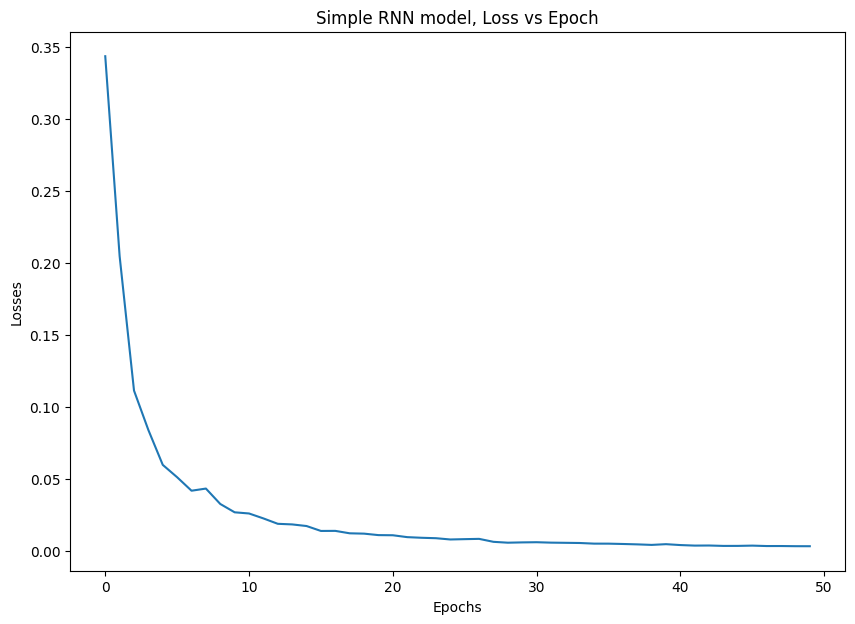

In [ ]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

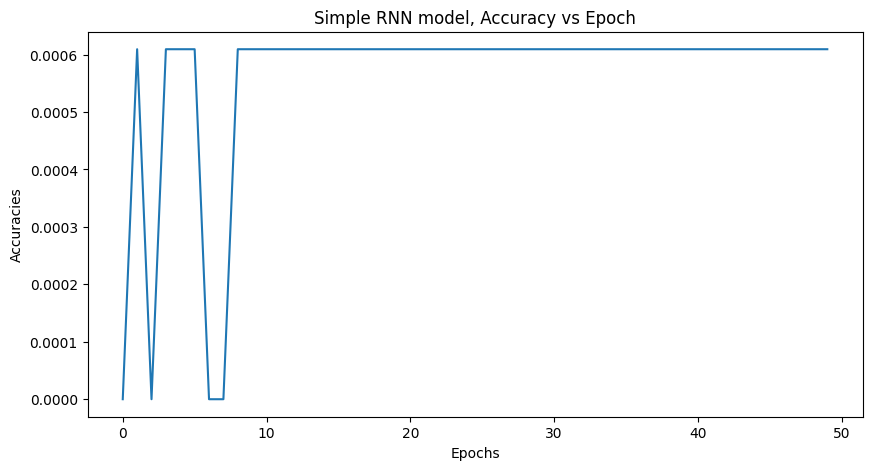

In [ ]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

## Model predictions for train data

In [ ]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

52/52 [==============================] - 1s 18ms/step


(1641, 1)

In [ ]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(1641, 1)

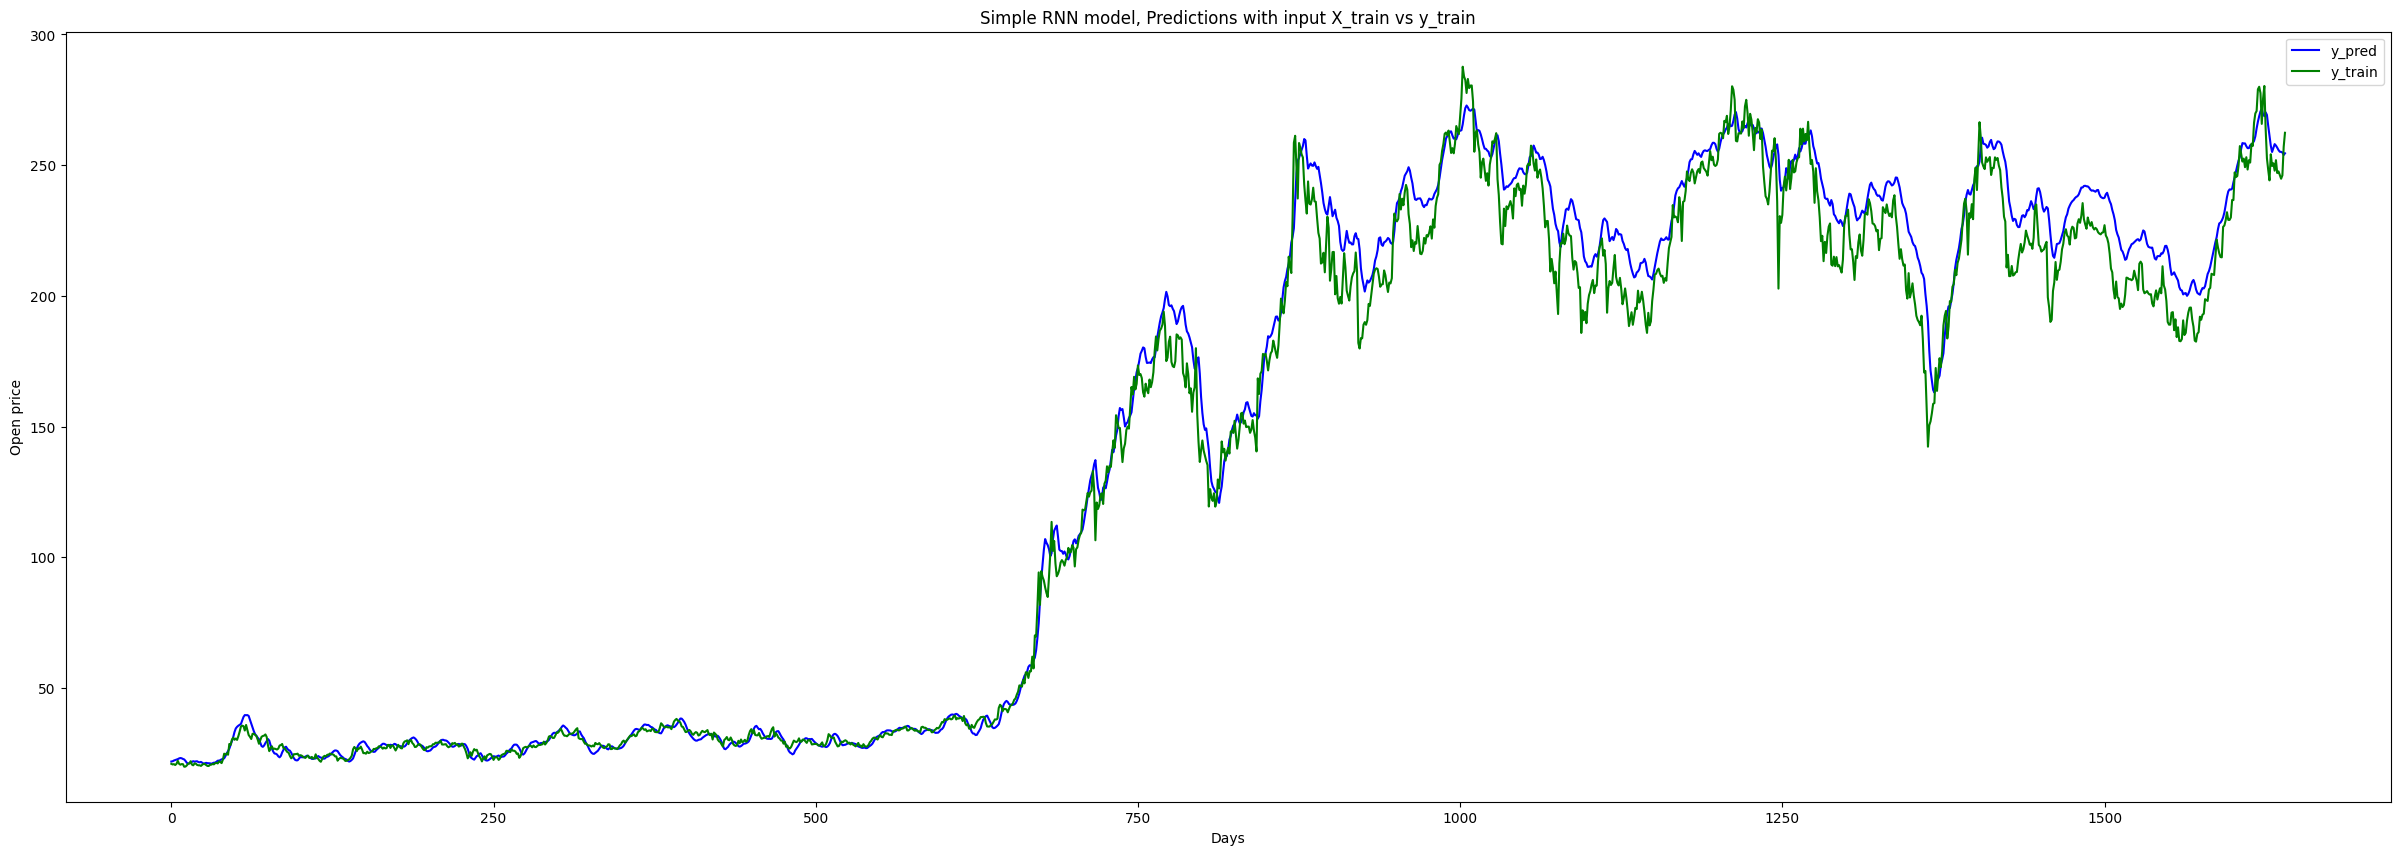

In [ ]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()


<a id="8"></a>
## 8.Creating Test Dataset from Validation Data

### Converting array and scaling

In [ ]:
dataset_validation = validation_data.Open.values  # getting "open" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (725, 1)


### Creating X_test and y_test

In [ ]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

### Converting to array

In [ ]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (675, 50)
Shape of y_test before reshape : (675,)


### Reshape

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [ ]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test after reshape : (675, 50, 1)
Shape of y_test after reshape : (675, 1)


<a id="9"></a>
## 9.Evaluating with Validation Data

In [ ]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test)
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

22/22 [==============================] - 0s 17ms/step
Shape of y_pred_of_test : (675, 1)


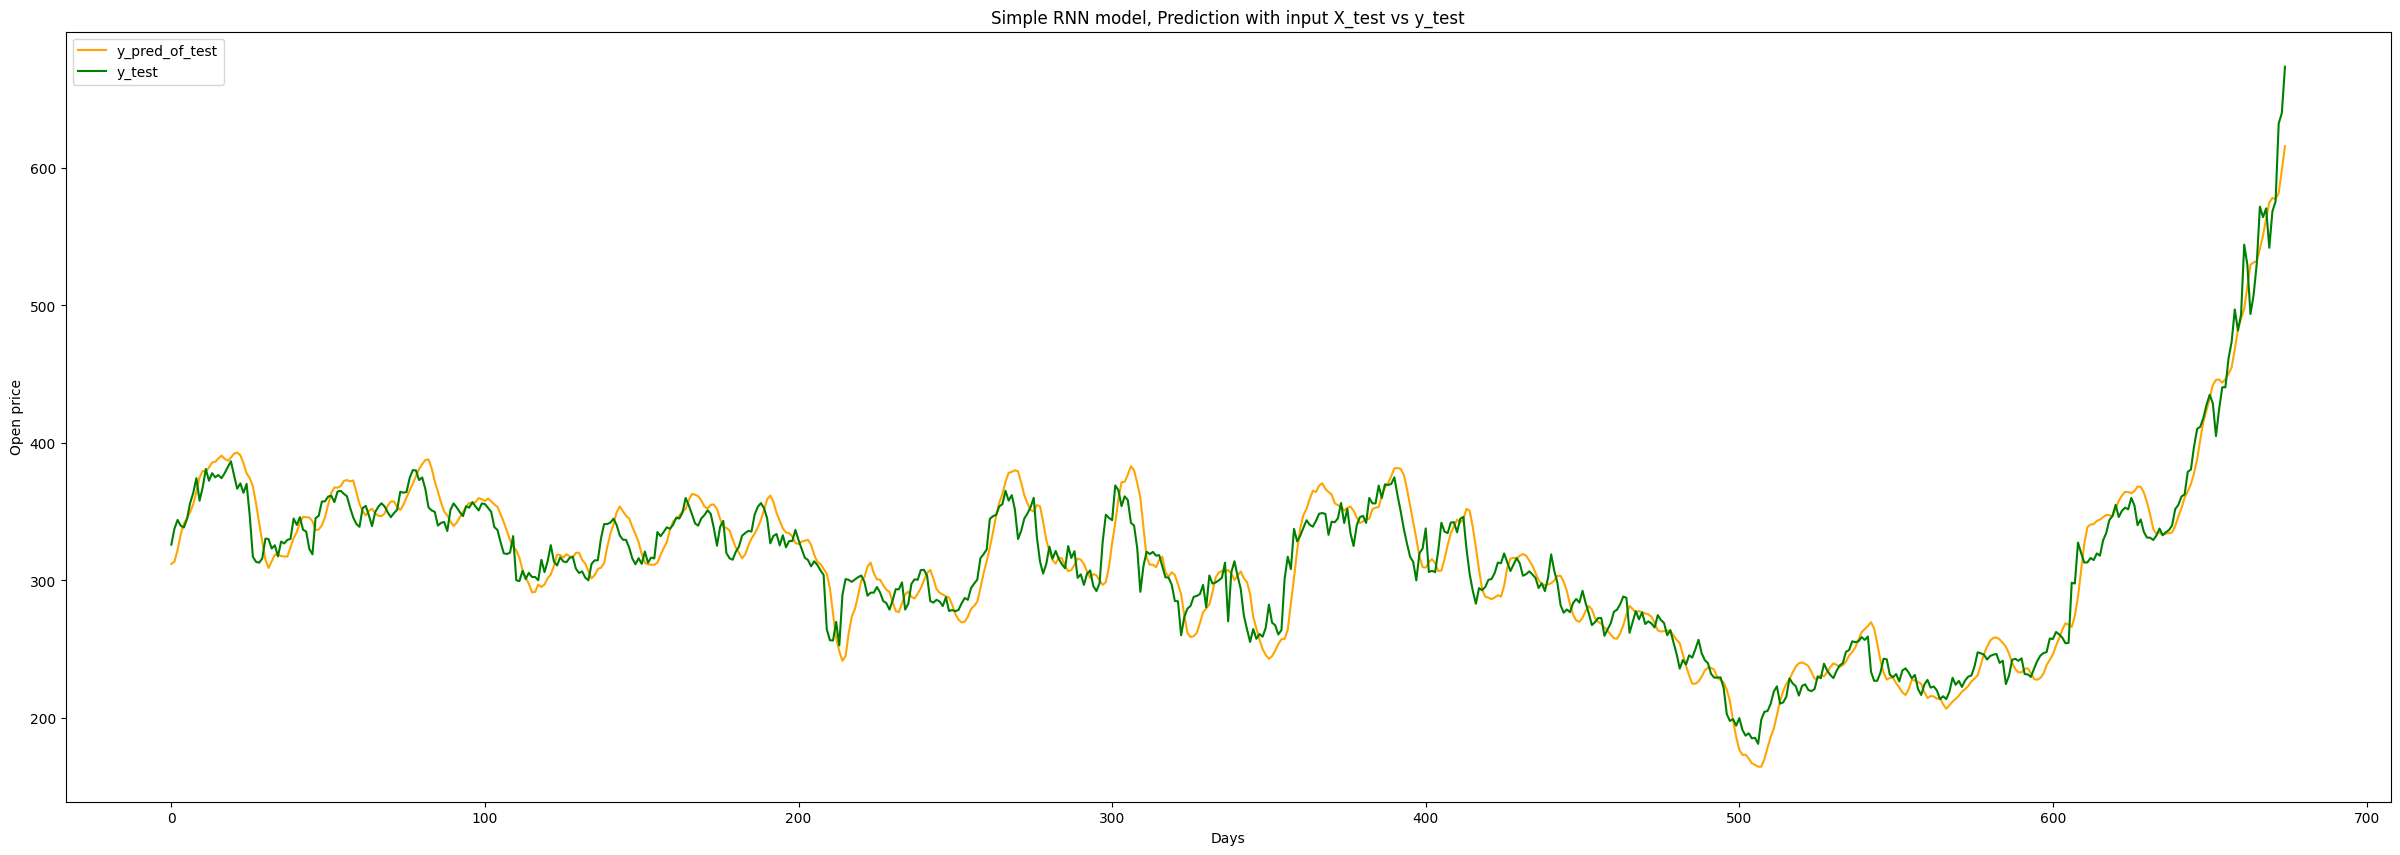

In [ ]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

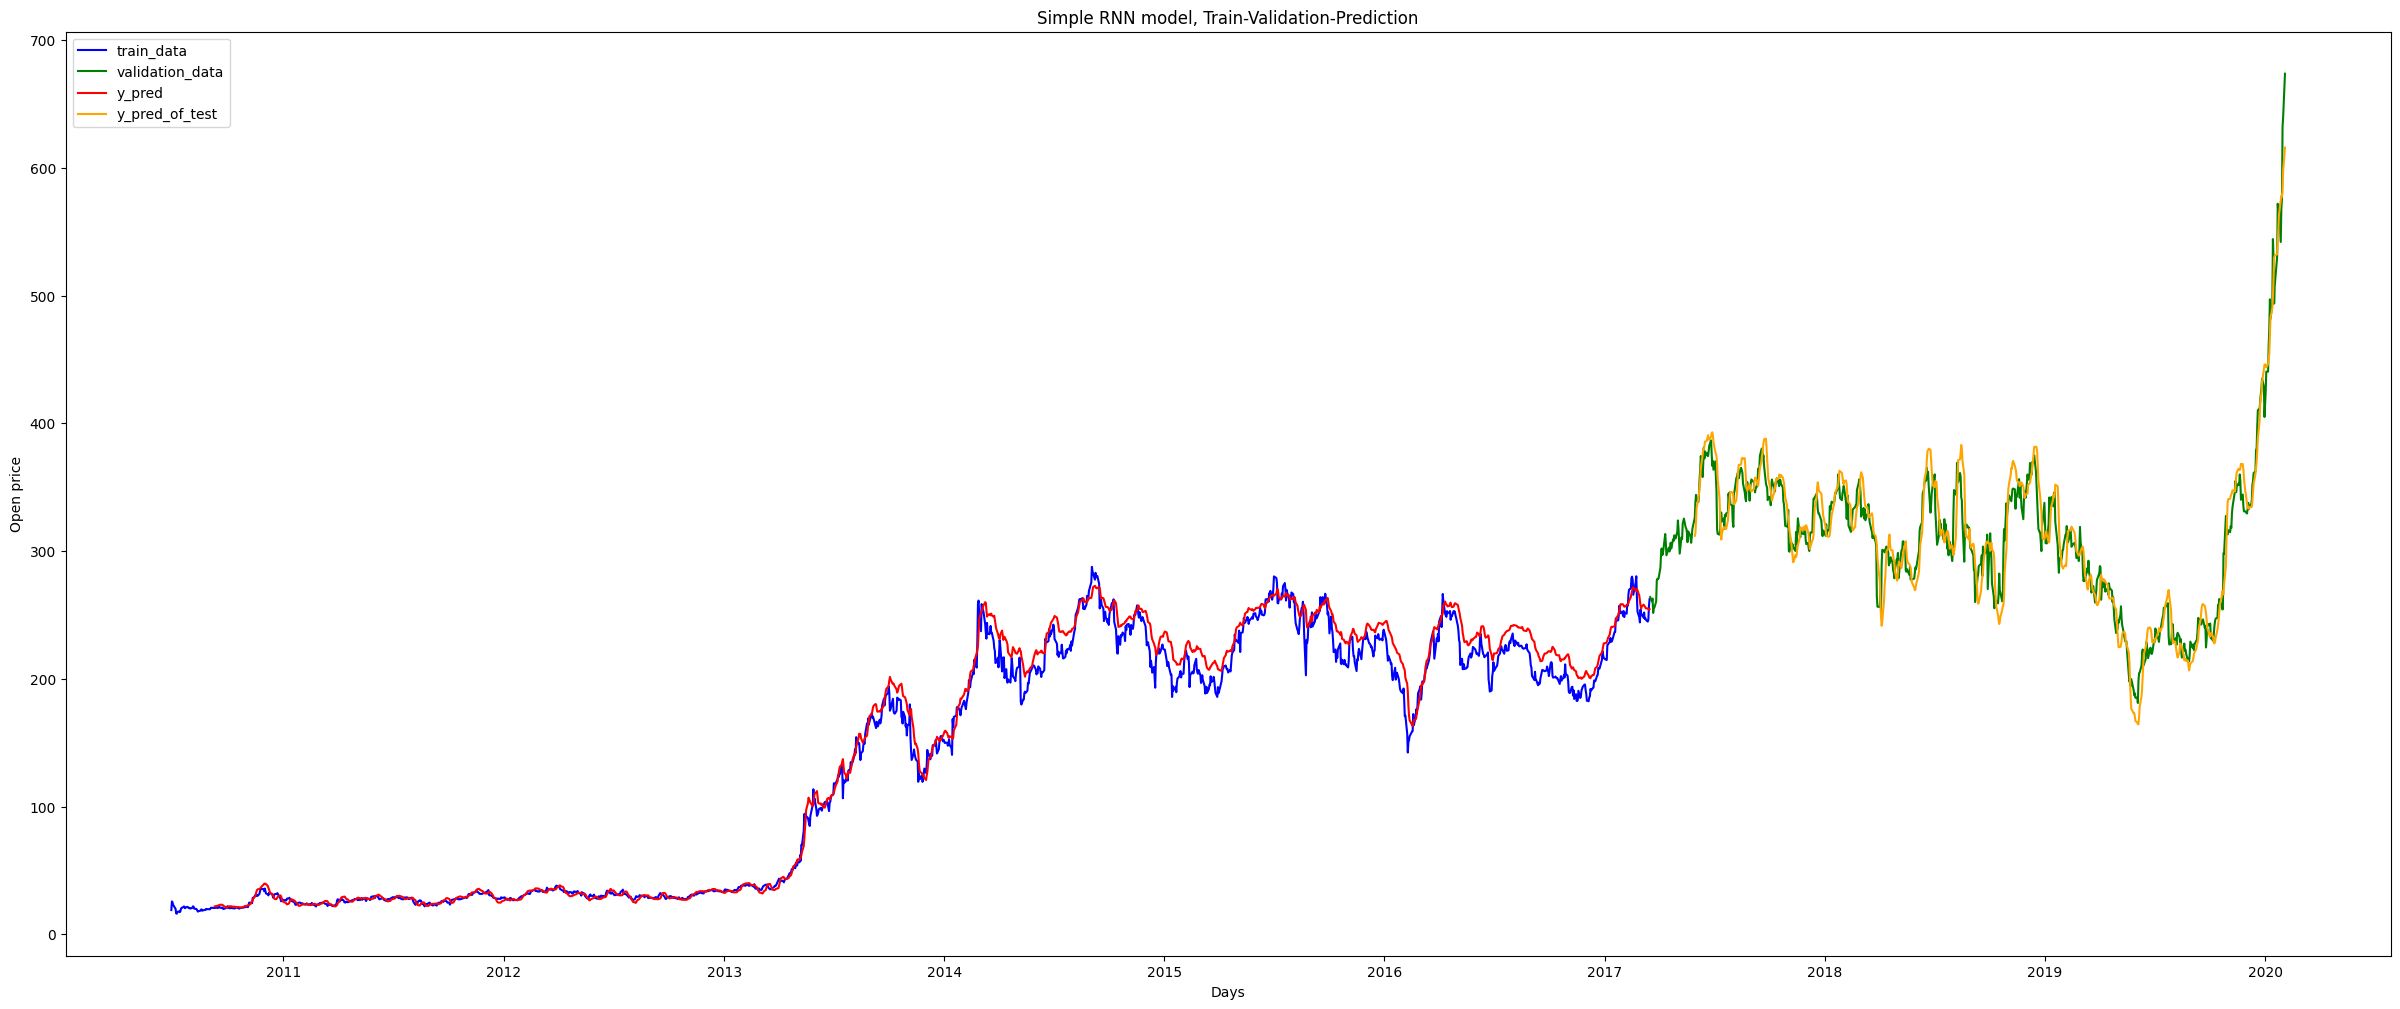

In [ ]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Open, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Open, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

<a id="10"></a>
## 10.Creating LSTM Model

In [ ]:
y_train = scaler.fit_transform(y_train)

In [ ]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)


Epoch 1/10
165/165 [==============================] - 6s 7ms/step - loss: 0.0085 - accuracy: 0.0012
Epoch 2/10
165/165 [==============================] - 1s 7ms/step - loss: 0.0015 - accuracy: 0.0012
Epoch 3/10
165/165 [==============================] - 1s 7ms/step - loss: 0.0012 - accuracy: 0.0012
Epoch 4/10
165/165 [==============================] - 1s 9ms/step - loss: 0.0011 - accuracy: 0.0012
Epoch 5/10
165/165 [==============================] - 2s 10ms/step - loss: 0.0011 - accuracy: 0.0012
Epoch 6/10
165/165 [==============================] - 1s 9ms/step - loss: 0.0011 - accuracy: 0.0012
Epoch 7/10
165/165 [==============================] - 1s 7ms/step - loss: 0.0010 - accuracy: 0.0012
Epoch 8/10
165/165 [==============================] - 1s 7ms/step - loss: 8.3524e-04 - accuracy: 0.0012
Epoch 9/10
165/165 [==============================] - 1s 7ms/step - loss: 7.2819e-04 - accuracy: 0.0012
Epoch 10/10
165/165 [==============================] - 1s 7ms/step - loss: 6.7582e-04 - acc

<a id="11"></a>
## 11.Evaluating LSTM Model

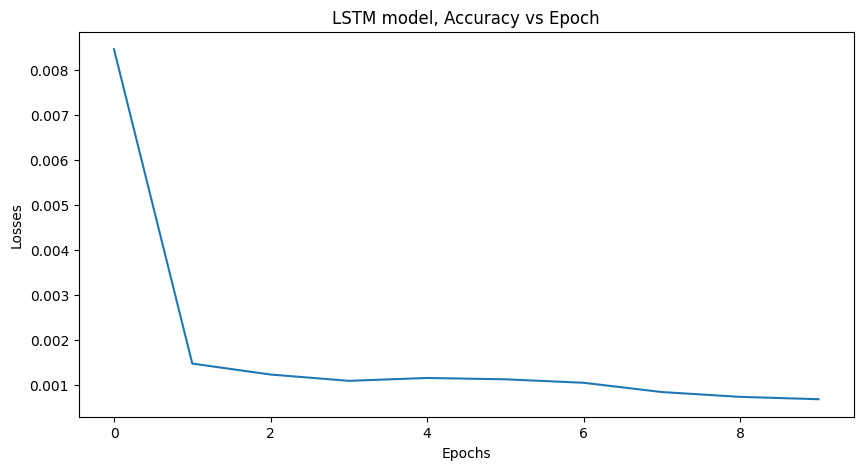

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

22/22 [==============================] - 1s 5ms/step


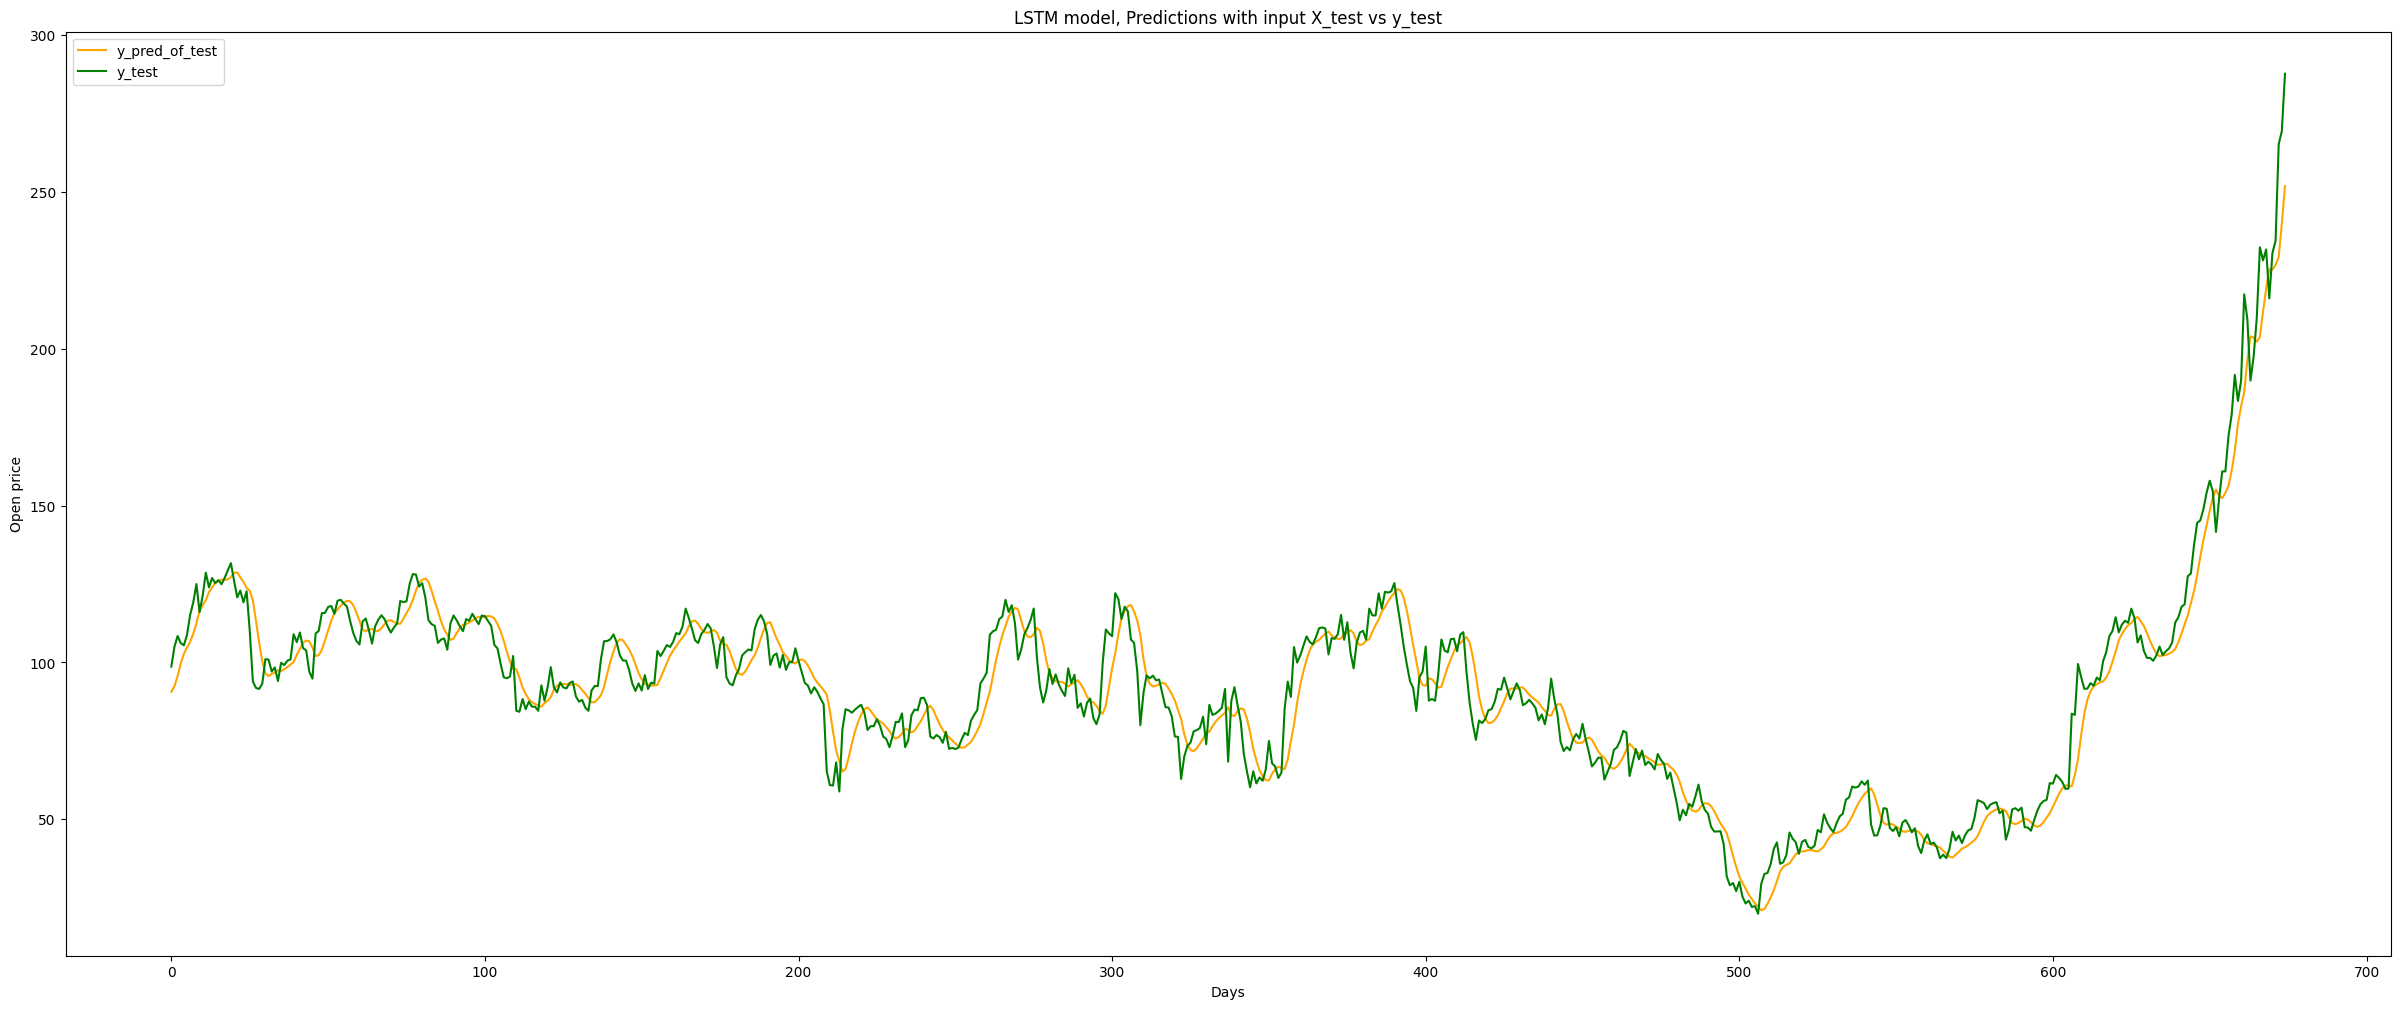

In [ ]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

<a id="12"></a>
## 12.Future price prediction

* Which day is the last day in our data?

In [ ]:
data.iloc[-1]

Date         2020-02-03
Open         673.690002
High         786.140015
Low           673.52002
Close             780.0
Adj Close         780.0
Volume         47065000
Name: 2415, dtype: object

* We can predict the open price for the day after 3/17/2017--> for  3/18/2017.
* We will use last 50 days Open price as input of our model for this prediction
* Let us prepare it:

In [ ]:
X_input = data.iloc[-time_step:].Open.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.08887858],
        [0.07293275],
        [0.03125275],
        [0.0433356 ],
        [0.01704957],
        [0.00499579],
        [0.00496672],
        [0.        ],
        [0.00935258],
        [0.02425283],
        [0.00996251],
        [0.01626537],
        [0.02088356],
        [0.03067181],
        [0.06529382],
        [0.07412361],
        [0.0919283 ],
        [0.09628509],
        [0.14403554],
        [0.14879901],
        [0.19727559],
        [0.23494732],
        [0.23927504],
        [0.25838679],
        [0.28612509],
        [0.30671818],
        [0.28868109],
        [0.21958234],
        [0.27622064],
        [0.32269309],
        [0.32260596],
        [0.38339771],
        [0.41912346],
        [0.4870894 ],
        [0.44262108],
        [0.47663308],
        [0.62406695],
        [0.58195129],
        [0.47735921],
        [0.51761593],
        [0.58337448],
        [0.70431908],
        [0.68212844],
        [0.70065934],
        [0.61747362],
        [0

In [ ]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Open price prediction for 2/04/2020      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction for 2/04/2020 :", LSTM_prediction[0,0])

1/1 [==============================] - 0s 21ms/step
Simple RNN, Open price prediction for 2/04/2020      : 631.12427
LSTM prediction, Open price prediction for 2/04/2020 : 635.23376


## Thanks for reading, please upvote:)